In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.modeling import models
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.time import Time
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval

### Function Definition

In [2]:
def load_image_from_filename_list(folder_path: str, filename_list: list, verbose: bool = False, prefix: str ="") -> list:
    _list            = [fits.open(folder_path + "/" + filename) for filename in filename_list]
    _image_list      = [i[0].data for i in _list]
    
    # if "flat" in folder_path:
    #     _filter          = [f[0].header["EXPOSURE"]<5.0 or f[0].header["FILTER"]!="I" for f in _list]  # ignore long exposure data for I-band for flat field
    #     for index, f in enumerate(_list):
    #         if _filter[index]:
    #             print(f[0].header["FILTER"], f[0].header["EXPOSURE"])
    
    if verbose:
        print("Print out %s information:"%(prefix))
        print("----------------------------------------------------------------------")
        for index, f in enumerate(_list):
            print("*****File #%d*****"%index)
            f.info()
            print(repr(f[0].header))
            print("----------------------------------------------------------------------")
    _image_array = np.array(_image_list)
    
    # if "flat" in folder_path:
    #     return _image_array[_filter]
    # else:
    #     return _image_array
    
    return _image_array
    
def exhaust_folder_and_get_folder_image_dict(folder_list: list, verbose: bool=False, debug_flag: bool=False) -> dict:
    folder_image_dict    = {}
    while len(folder_list) != 0:
        current_folder            = folder_list[0]
        things_under_current_path = os.listdir(current_folder)
        fits_file_list            = list(filter(lambda thing: ".fit" in thing and "Master" not in thing and "corrected" not in thing, things_under_current_path))
        is_folder_list            = [current_folder + "/" + folder for folder in (filter(lambda thing: os.path.isdir(current_folder + "/" + thing), things_under_current_path))]
        folder_list              += is_folder_list
        del folder_list[0]
        
        if len(fits_file_list) != 0:
            folder_image_dict[current_folder] = fits_file_list
             
        if debug_flag:
            if len(fits_file_list) == 0:
                print("No FITS file under folder %s ."%current_folder)
            else:
                print("FITS file(s) list under current folder %s :"%current_folder)
                for i, fits_file in enumerate(fits_file_list):
                    print( "\t#%3d: %s\n"%(i, current_folder + "/" + fits_file) )
    return folder_image_dict

def plot_image(image_array: np.array, dpi: np.int32, cmap: str, norm_type: str, title: str, save_fig_flag: bool=False, save_fig_name:str="image"):
    fig = plt.figure(figsize=(3.3,4.4), dpi=dpi)
    ax  = plt.subplot(111)

    v_min, v_max = ZScaleInterval().get_limits(values=image_array)
    norm         = simple_norm(image_array, stretch=norm_type, percent=100.)
    ax.imshow(image_array, origin='lower', vmin=v_min, vmax=v_max, cmap=cmap)
    ax.axis("off")
    ax.set_title(title, fontsize=12., weight="bold")
    if save_fig_flag:
        save_file_path = "./"
        plt.savefig("%s/%s.png"%(save_file_path,save_fig_name), bbox_inches='tight', dpi=dpi, pad_inches=0.02, facecolor='white', transparent=True)

In [3]:
FITS_ROOT_PATH = "./FITS_SDSS_Elliptical_Galaxy"

folder_temp = os.listdir(FITS_ROOT_PATH)

object_folder        = list(filter(lambda folder: "SDSS"          in folder and "raw" in folder, folder_temp))[0]
standard_star_folder = list(filter(lambda folder: "standard_star" in folder and "raw" in folder, folder_temp))[0]
flat_folder          = list(filter(lambda folder: "flat"          in folder, folder_temp))[0]
bias_folder          = list(filter(lambda folder: "bias"          in folder, folder_temp))[0]
dark_folder          = list(filter(lambda folder: "dark"          in folder, folder_temp))[0]

print(object_folder, standard_star_folder, flat_folder, bias_folder, dark_folder)

SDSS2258+0017_raw standard_star_SA114_raw flat_field bias_field dark_field


#### Get master bias for different temperatures

In [8]:
folder_image_dict = exhaust_folder_and_get_folder_image_dict([FITS_ROOT_PATH+"/"+bias_folder], verbose=False, debug_flag=False)
for folder_temp in folder_image_dict.keys():
    bias_image_array = load_image_from_filename_list(folder_temp, folder_image_dict[folder_temp], verbose=False, prefix="Bias")

    with fits.open("%s/%s"%(folder_temp, folder_image_dict[folder_temp][0])) as hdul:
        header = hdul[0].header

    
    master_bias      = bias_image_array.mean(axis=0)
    hdu_master_bias  = fits.PrimaryHDU(master_bias)

    hdu_master_bias.header = header

    print(repr(hdu_master_bias.header))
    print("-------------------------------------------------------------------------------------------------")
    print(bias_image_array.shape)
    
    time_now                       = Time.now()
    temperature                    = folder_temp.split("/")[-1]
    hdu_master_bias.header["BZERO"]    = 0.0  # important!! Do not shift the np.array value when writing FITS files
    hdu_master_bias.header["DATE-OBS"] = (time_now.isot, "YYYY-MM-DDThh:mm:ss processing is done, UT")
    hdu_master_bias.header["CCD-TEMP"] = (hdu_master_bias.header["SET-TEMP"],"Set as SET-TEMP for master image")
    hdu_master_bias.header["IMAGETYP"] = "Bias Frame (Master)"
    hdu_master_bias.header["JD"]       = (time_now.jd, "Julian Date for proceesing")
    hdu_master_bias.header["NOTES"]    = "Master image obtained by averaging."
    hdu_master_bias.header["OBJECT"]   = "Bias_Master_%s"%temperature

    print(repr(hdu_master_bias.header))
    print("=================================================================================================")
    
    hdu_master_bias.writeto("%s/Bias-Master_%s.fit"%(folder_temp,temperature), overwrite=True) # overwrite the FITS file if it already exists

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / 8 unsigned int, 16 & 32 int, -32 & -64 real    
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 5832 /fastest changing axis                           
NAXIS2  =                 4375 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2023-03-30T11:04:24' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =  0.00000000000000000 /Exposure time in seconds                        
EXPOSURE=  0.00000000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -14.936843872070313 /CCD temperature at start of exposure in C       
XPIXSZ  =   7.51999999999999

#### Get master dark at different temperature and integration time

In [9]:
folder_image_dict = exhaust_folder_and_get_folder_image_dict([FITS_ROOT_PATH+"/"+dark_folder], verbose=False, debug_flag=False)
for folder_temp in folder_image_dict.keys():
    dark_image_array = load_image_from_filename_list(folder_temp, folder_image_dict[folder_temp], verbose=False, prefix="Dark")

    with fits.open("%s/%s"%(folder_temp, folder_image_dict[folder_temp][0])) as hdul:
        header = hdul[0].header

    master_dark      = dark_image_array.mean(axis=0)
    hdu_master_dark  = fits.PrimaryHDU(master_dark)

    hdu_master_dark.header = header

    print(repr(hdu_master_dark.header))
    print("-------------------------------------------------------------------------------------------------")
    time_now                       = Time.now()
    temperature                    = folder_temp.split("/")[-2]
    exposure                       = folder_temp.split("/")[-1]
    hdu_master_dark.header["BZERO"]    = 0.0  # important!! Do not shift the np.array value when writing FITS files
    hdu_master_dark.header["DATE-OBS"] = (time_now.isot, "YYYY-MM-DDThh:mm:ss processing is done, UT")
    hdu_master_dark.header["CCD-TEMP"] = (hdu_master_dark.header["SET-TEMP"],"Set as SET-TEMP for master image")
    hdu_master_dark.header["IMAGETYP"] = "Dark Frame (Master)"
    hdu_master_dark.header["JD"]       = (time_now.jd, "Julian Date for proceesing")
    hdu_master_dark.header["NOTES"]    = "Master image obtained by averaging."
    hdu_master_dark.header["OBJECT"]   = "Dark_Master_%s_%s"%(temperature,exposure)

    print(repr(hdu_master_dark.header))
    print("=================================================================================================")
    
    hdu_master_dark.writeto("%s/Dark-Master_%s_%s.fit"%(folder_temp,temperature,exposure), overwrite=True) # overwrite the FITS file if it already exists

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / 8 unsigned int, 16 & 32 int, -32 & -64 real    
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 5832 /fastest changing axis                           
NAXIS2  =                 4375 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2023-03-30T11:40:22' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   300.00000000000000 /Exposure time in seconds                        
EXPOSURE=   300.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -14.941238403320313 /CCD temperature at start of exposure in C       
XPIXSZ  =   7.51999999999999

#### Get master flat at different temperature and integration time
  Carful check will find that the flat iamges contain stars, since we use twilight flat. To solve the star problem, instead of averaging the flats, you need to use medium,
which removes outliers like stars. (The flat exposures were dithered, so a star in different exposures have different positions.). Detail procedures are listed as below:
  1. Subtract the bias for each flat
  2. Normalize each flat to have unit mean over the whole image
  3. Medium combining all the flats
  4. Normalize again such that the final flat image will have unit mean pixel value


Simple check for the code

In [22]:
array_test = np.arange(8).reshape(2,2,2)
bias_test  = -np.arange(4).reshape(2,2)

array_test = (array_test - bias_test)                             # subtract (N_x, N_y) master bias for each flat_image flat_image_array[i,:,:] 
array_test = array_test.reshape(2, -1)                        # reshape the result array from (N_image, N_x, N_y) -> (N_image, N_x*N_y)
print(array_test.shape) 
normalization  = array_test.sum(axis=1).reshape(-1,1)                   # compute normalization along axis=1 for the reshaped array, to normalize each image
array_test     = (array_test/normalization).reshape(2,2,2)  # divided each iamge by the normalization

(2, 4)


In [4]:
folder_image_dict = exhaust_folder_and_get_folder_image_dict([FITS_ROOT_PATH+"/"+flat_folder], verbose=False, debug_flag=False)
for folder_temp in folder_image_dict.keys():
    flat_image_array = load_image_from_filename_list(folder_temp, folder_image_dict[folder_temp], verbose=False, prefix="Flat")

    with fits.open("%s/%s"%(folder_temp, folder_image_dict[folder_temp][0])) as hdul:
        header = hdul[0].header
        
    # print(repr(header))
    temperature_str = "%.0f"%(header["SET-TEMP"])
    
    with fits.open("%s/bias_field/%sdegC/Bias-Master_%sdegC.fit"%(FITS_ROOT_PATH, temperature_str, temperature_str)) as hdul_master_bias:
        if np.float64(temperature_str) != np.float64(hdul_master_bias[0].header["SET-TEMP"]):
            raise RuntimeError( "temperature (%.0f) != master_bias_temperature (%.0f) !! Exit!!"%(np.float64(temperature_str), np.float64(hdul_master_bias[0].header["SET-TEMP"])) )
        master_bias = hdul_master_bias[0].data 
    
    N_image, N_x, N_y = flat_image_array.shape
    flat_image_array  = (flat_image_array - master_bias)                             # subtract (N_x, N_y) master bias for each flat_image flat_image_array[i,:,:] 
    flat_image_array  = flat_image_array.reshape(N_image, -1)                        # reshape the result array from (N_image, N_x, N_y) -> (N_image, N_x*N_y)
    normalization     = flat_image_array.mean(axis=1).reshape(-1,1)                  # compute normalization along axis=1 for the reshaped array, to normalize each image
    flat_image_array  = (flat_image_array/normalization).reshape(N_image, N_x, N_y)  # divided each iamge by the normalization 
    master_flat       = np.median(flat_image_array, axis=0)                          # do medium combination
    master_flat      /= master_flat.mean()                                           # do final normalization
    hdu_master_flat   = fits.PrimaryHDU(master_flat)

    hdu_master_flat.header = header

    # print(repr(hdu_master_flat.header))
    # print("-------------------------------------------------------------------------------------------------")
    time_now                           = Time.now()
    band_filter                        = folder_temp.split("/")[-1]
    hdu_master_flat.header["BZERO"]    = 0.0  # important!! Do not shift the np.array value when writing FITS files
    hdu_master_flat.header["DATE-OBS"] = (time_now.isot, "YYYY-MM-DDThh:mm:ss processing is done, UT")
    hdu_master_flat.header["CCD-TEMP"] = (hdu_master_flat.header["SET-TEMP"],"Set as SET-TEMP for master image")
    hdu_master_flat.header["IMAGETYP"] = "Flat Field (Master)"
    hdu_master_flat.header["JD"]       = (time_now.jd, "Julian Date for proceesing")
    hdu_master_flat.header["JD-HELIO"] = ""
    hdu_master_flat.header["NOTES"]    = "Master image obtained by subtracting master bias then medium combined."
    hdu_master_flat.header["OBJECT"]   = "Twilight_Flat_%s_Master_%sdegC"%(band_filter, temperature_str)
    hdu_master_flat.header["EXPTIME"]  = ""
    hdu_master_flat.header["EXPOSURE"] = ""
    hdu_master_flat.header["OBJCTRA"]  = ""
    hdu_master_flat.header["OBJCTDEC"] = ""
    hdu_master_flat.header["OBJCTALT"] = ""
    hdu_master_flat.header["OBJCTAZ"]  = ""
    hdu_master_flat.header["OBJCTHA"]  = ""
    hdu_master_flat.header["AIRMASS"]  = ""
    
    print(repr(hdu_master_flat.header))
    print("=================================================================================================")
    hdu_master_flat.writeto("%s/Flat-Master_%s.fit"%(folder_temp,band_filter), overwrite=True) # overwrite the FITS file if it already exists
    
    # if hdu_master_flat.header["FILTER"] == "I":
    #     hdu_master_flat.writeto("%s/Flat-Master_%s.fit"%(folder_temp,band_filter), overwrite=True) # overwrite the FITS file if it already exists

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / 8 unsigned int, 16 & 32 int, -32 & -64 real    
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 5832 /fastest changing axis                           
NAXIS2  =                 4375 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =                  0.0 / physical = BZERO + BSCALE*array_value          
DATE-OBS= '2023-12-23T21:00:20.202' / YYYY-MM-DDThh:mm:ss processing is done, UT
EXPTIME = '' / Exposure time in seconds                                         
EXPOSURE= '' / Exposure time in seconds                                         
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=                -15.0 / Set as SET-TEMP for master image               
XPIXSZ  =   7.51999999999999

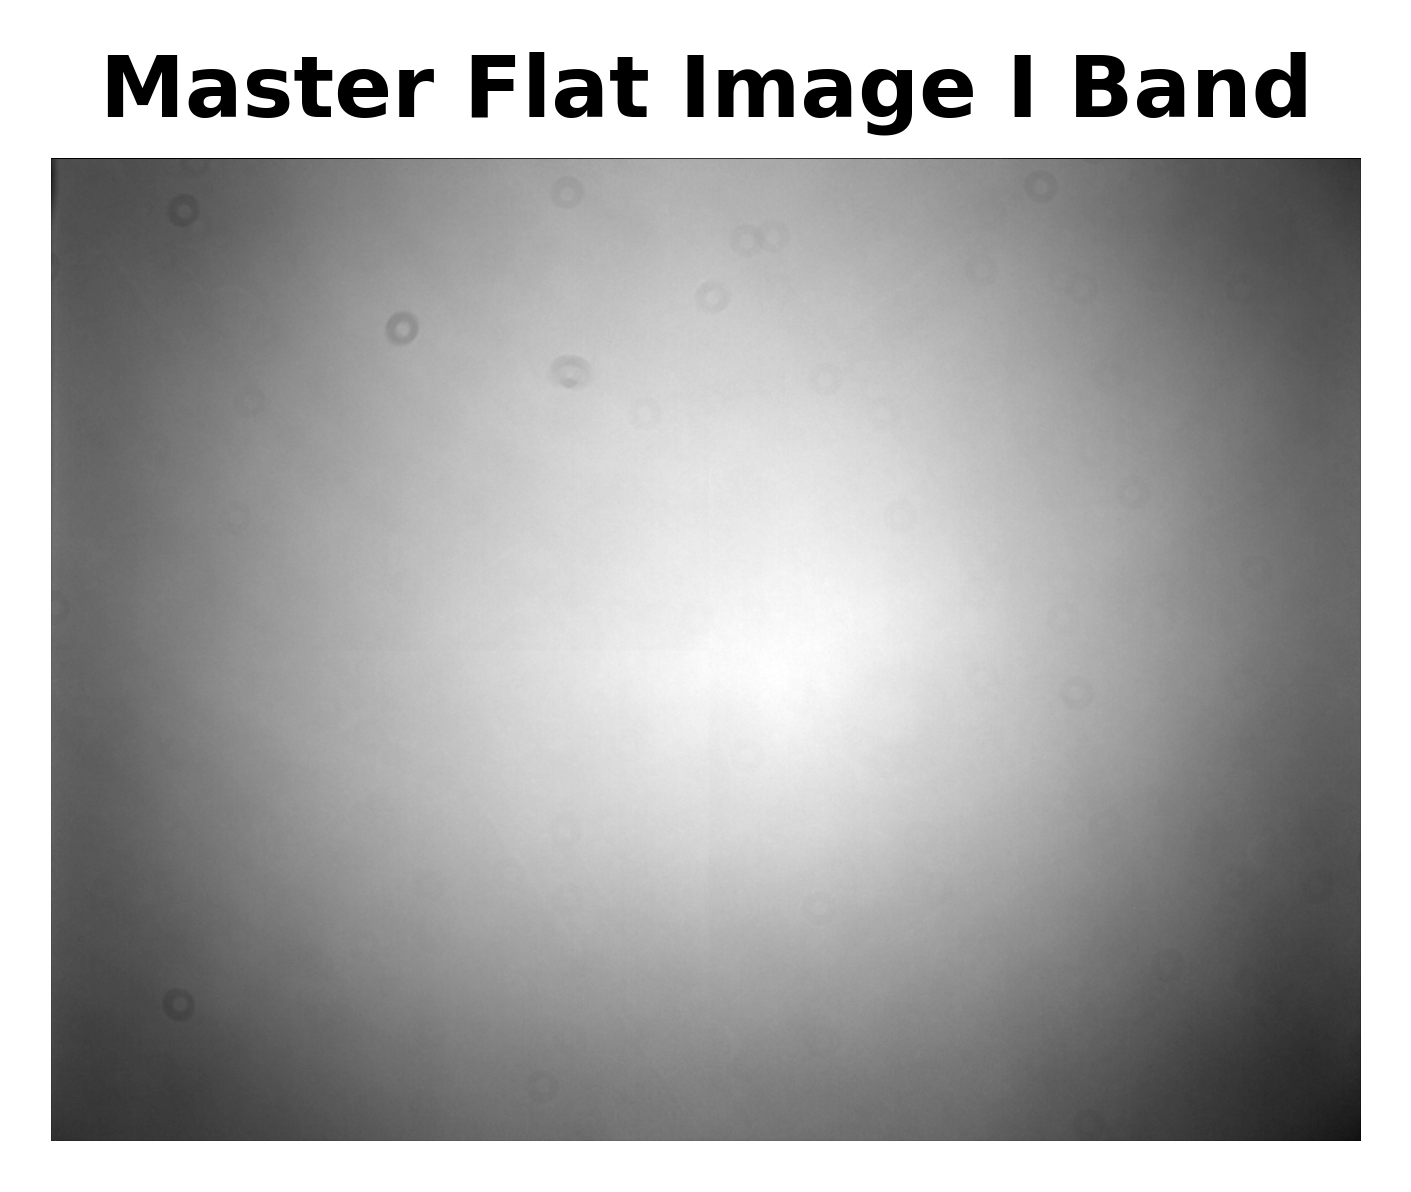

In [8]:
band_filter = "I"
with fits.open("%s/flat_field/%s/Flat-Master_%s.fit"%(FITS_ROOT_PATH, band_filter, band_filter)) as hdul_temp:
    master_flat_image = hdul_temp[0].data
plot_image(master_flat_image, dpi=512, cmap="gray", norm_type="log", title="Master Flat Image %s Band"%band_filter, save_fig_flag=False, save_fig_name="master_flat_%s_band"%band_filter)

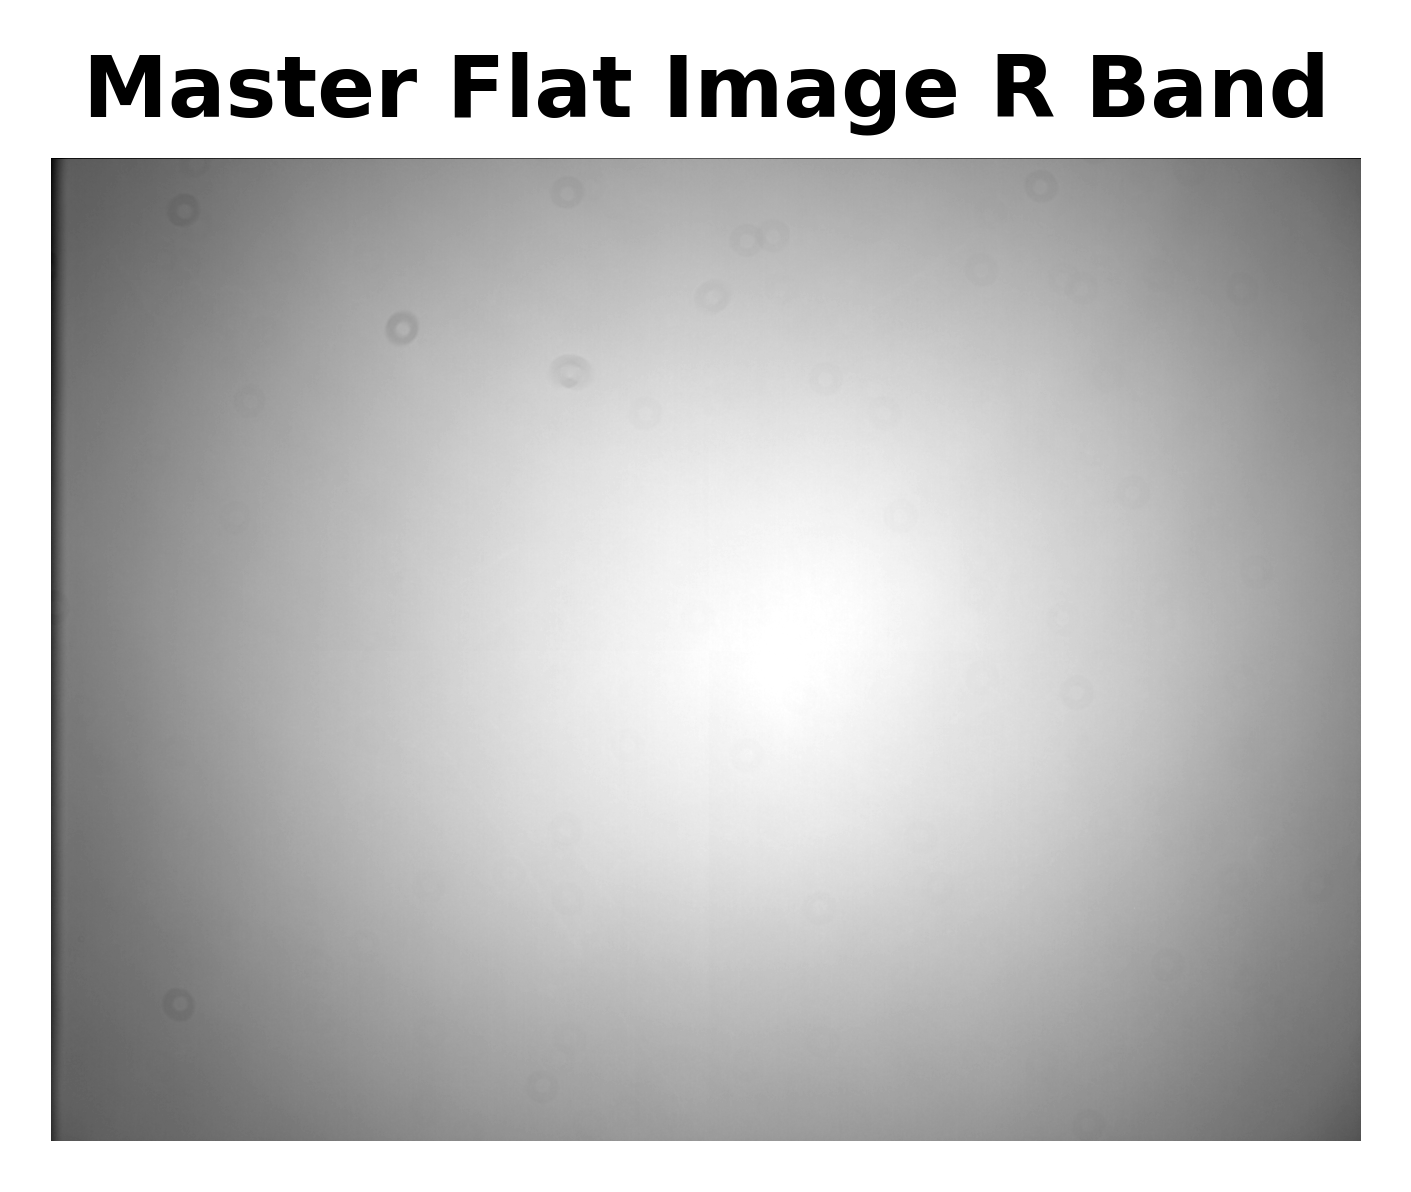

In [6]:
band_filter = "R"
with fits.open("%s/flat_field/%s/Flat-Master_%s.fit"%(FITS_ROOT_PATH, band_filter, band_filter)) as hdul_temp:
    master_flat_image = hdul_temp[0].data
plot_image(master_flat_image, dpi=512, cmap="gray", norm_type="log", title="Master Flat Image %s Band"%band_filter, save_fig_flag=False, save_fig_name="master_flat_%s_band"%band_filter)

#### Correct each object image using master flat, master bias and master dark

In [10]:
folder_image_corrected    = FITS_ROOT_PATH + "/SDSS2258+0017_corrected/"
folder_image_dict         = exhaust_folder_and_get_folder_image_dict([FITS_ROOT_PATH+"/"+object_folder], verbose=False, debug_flag=False)
for folder_temp in folder_image_dict.keys():
    # if "/I" not in folder_temp:
    #     continue
    object_image_namelist = folder_image_dict[folder_temp]
    for object_image_name in object_image_namelist:
        
        with fits.open("%s/%s"%(folder_temp, object_image_name)) as hdul_object:
            object_header = hdul_object[0].header
            object_image  = hdul_object[0].data
        
        exposure_str      = object_header["EXPOSURE"]
        temperature_str   = object_header["SET-TEMP"]
        band_filter       = object_header["FILTER"]
        exposure          = np.float64(exposure_str)  # in unit of second
        temperature       = np.float64(temperature_str)
        
        # print(repr(object_header))
        # print("-------------------------------------------------------------------------------------------------")
        
        # load necessary fits for correction 
        ### master bias
        with fits.open("%s/bias_field/%.0fdegC/Bias-Master_%.0fdegC.fit"%(FITS_ROOT_PATH, temperature, temperature)) as hdul_master_bias:
            if temperature != np.float64(hdul_master_bias[0].header["SET-TEMP"]):
                raise RuntimeError( "temperature (%.0f) != master_bias_temperature (%.0f) !! Exit!!"%(temperature, np.float64(hdul_master_bias[0].header["SET-TEMP"])) )
            master_bias  = hdul_master_bias[0].data
        
        ### master dark
        if exposure > 60.: expos_filename_str = "%.0fmin"%(exposure//60)
        else:              expos_filename_str = "%.0fsec"%(exposure//1) 
        with fits.open("%s/dark_field/%.0fdegC/%s/Dark-Master_%.0fdegC_%s.fit"%(FITS_ROOT_PATH, temperature, expos_filename_str, temperature, expos_filename_str)) as hdul_master_dark:
            if temperature != np.float64(hdul_master_dark[0].header["SET-TEMP"]):
                raise RuntimeError( "temperature (%.0f) != master_dark_temperature (%.0f) !! Exit!!"%(temperature, np.float64(hdul_master_dark[0].header["SET-TEMP"])) )
            if exposure    != np.float64(hdul_master_dark[0].header["EXPOSURE"]):
                raise RuntimeError( "exposure (%.0f)    != master_dark_exposure    (%.0f) !! Exit!!"%(exposure,    np.float64(hdul_master_dark[0].header["EXPOSURE"])) )
            master_dark  = hdul_master_dark[0].data
        
        ### master flat
        with fits.open("%s/flat_field/%s/Flat-Master_%s.fit"%(FITS_ROOT_PATH, band_filter, band_filter)) as hdul_master_flat:
            if band_filter != hdul_master_flat[0].header["FILTER"]:
                raise RuntimeError( "band_filter (%s) != master_flat_band_filter (%s) !! Exit!!"%(band_filter, hdul_master_flat[0].header["FILTER"]) )
            master_flat  = hdul_master_flat[0].data
        
        # do image correction
        object_image_correct      = ( (object_image-master_bias) - (master_dark-master_bias) )/exposure/master_flat
        print(exposure, temperature, band_filter)
        hdu_object_correct        = fits.PrimaryHDU(object_image_correct)
        hdu_object_correct.header = object_header
        time_now                  = Time.now()
        
        if band_filter == "B" and "20231012" in object_image_name: # somehow the OBJCTRA and OBJCTDEC is missed in fits file for B band on 20231012
            hdu_object_correct.header["OBJCTRA"] = ("22 58 00", "Nominal Right Ascension of center of image")      
            hdu_object_correct.header["OBJCTDEC"] = ("+00 17 45", "Nominal Declination of center of image")
        hdu_object_correct.header["BZERO"]     = 0.0  # important!! Do not shift the np.array value when writing FITS files
        hdu_object_correct.header["DATE-PRO"]  = (time_now.isot, "YYYY-MM-DDThh:mm:ss processed, UT")
        hdu_object_correct.header["CCD-TEMP"]  = (hdul_object[0].header["SET-TEMP"],"Set as SET-TEMP for corrected image")
        hdu_object_correct.header["IMAGETYP"]  = hdul_object[0].header["IMAGETYP"] + " (Corrected)" 
        hdu_object_correct.header["NOTES"]     = "Corrected image obtained by subtracting master bias and master bias, then divided by master flat."
        hdu_object_correct.header["OBJECT"]    = hdul_object[0].header["OBJECT"] + "_Corrected"
        
        print(object_image_name)
        print(repr(hdu_object_correct.header))
        print("=================================================================================================")
        
        save_path = "%s/%s/"%(folder_image_corrected,band_filter)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        hdu_object_correct.writeto("%s/%s_corrected.fit"%(save_path,object_image_name.split(".")[0]), overwrite=True) # overwrite the FITS file if it already exists

300.0 -15.0 I
20231026_SDSS2258+0017_I_5min-004.fit
SIMPLE  =                    T                                                  
BITPIX  =                  -64 / 8 unsigned int, 16 & 32 int, -32 & -64 real    
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 5832 /fastest changing axis                           
NAXIS2  =                 4375 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =                  0.0 / physical = BZERO + BSCALE*array_value          
DATE-OBS= '2023-10-26T12:15:26' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   300.00000000000000 /Exposure time in seconds                        
EXPOSURE=   300.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=                -15.0 / Set as SET-TEMP for corr

#### Correct standard stars image

In [12]:
folder_image_corrected    = FITS_ROOT_PATH + "/standard_star_SA114_corrected/"
folder_image_dict         = exhaust_folder_and_get_folder_image_dict([FITS_ROOT_PATH+"/"+standard_star_folder], verbose=False, debug_flag=False)
for folder_temp in folder_image_dict.keys():
    # if "/I" not in folder_temp:
    #     continue
    object_image_namelist = folder_image_dict[folder_temp]
    for object_image_name in object_image_namelist:
        
        with fits.open("%s/%s"%(folder_temp, object_image_name)) as hdul_object:
            object_header = hdul_object[0].header
            object_image  = hdul_object[0].data
        
        exposure_str      = object_header["EXPOSURE"]
        temperature_str   = object_header["SET-TEMP"]
        band_filter       = object_header["FILTER"]
        exposure          = np.float64(exposure_str)  # in unit of second
        temperature       = np.float64(temperature_str)
        
        print(repr(object_header))
        print("-------------------------------------------------------------------------------------------------")
        
        # load necessary fits for correction 
        ### master bias
        with fits.open("%s/bias_field/%.0fdegC/Bias-Master_%.0fdegC.fit"%(FITS_ROOT_PATH, temperature, temperature)) as hdul_master_bias:
            if temperature != np.float64(hdul_master_bias[0].header["SET-TEMP"]):
                raise RuntimeError( "temperature (%.0f) != master_bias_temperature (%.0f) !! Exit!!"%(temperature, np.float64(hdul_master_bias[0].header["SET-TEMP"])) )
            master_bias  = hdul_master_bias[0].data
        
        ### master dark
        if exposure > 60.: expos_filename_str = "%.0fmin"%(exposure//60)
        else:              expos_filename_str = "%.0fsec"%(exposure//1) 
        with fits.open("%s/dark_field/%.0fdegC/%s/Dark-Master_%.0fdegC_%s.fit"%(FITS_ROOT_PATH, temperature, expos_filename_str, temperature, expos_filename_str)) as hdul_master_dark:
            if temperature != np.float64(hdul_master_dark[0].header["SET-TEMP"]):
                raise RuntimeError( "temperature (%.0f) != master_dark_temperature (%.0f) !! Exit!!"%(temperature, np.float64(hdul_master_dark[0].header["SET-TEMP"])) )
            if exposure    != np.float64(hdul_master_dark[0].header["EXPOSURE"]):
                raise RuntimeError( "exposure (%.0f)    != master_dark_exposure    (%.0f) !! Exit!!"%(exposure,    np.float64(hdul_master_dark[0].header["EXPOSURE"])) )
            master_dark  = hdul_master_dark[0].data
        
        ### master flat
        with fits.open("%s/flat_field/%s/Flat-Master_%s.fit"%(FITS_ROOT_PATH, band_filter, band_filter)) as hdul_master_flat:
            if band_filter != hdul_master_flat[0].header["FILTER"]:
                raise RuntimeError( "band_filter (%s) != master_flat_band_filter (%s) !! Exit!!"%(band_filter, hdul_master_flat[0].header["FILTER"]) )
            master_flat  = hdul_master_flat[0].data
        
        # do image correction
        object_image_correct      = ( (object_image-master_bias) - (master_dark-master_bias) )/exposure/master_flat
        print(master_flat.mean())
        print(exposure, temperature, band_filter)
        hdu_object_correct        = fits.PrimaryHDU(object_image_correct)
        hdu_object_correct.header = object_header
        time_now                  = Time.now()
        
        hdu_object_correct.header["BZERO"]     = 0.0  # important!! Do not shift the np.array value when writing FITS files
        hdu_object_correct.header["DATE-PRO"]  = (time_now.isot, "YYYY-MM-DDThh:mm:ss processed, UT")
        hdu_object_correct.header["CCD-TEMP"]  = (hdul_object[0].header["SET-TEMP"],"Set as SET-TEMP for corrected image")
        hdu_object_correct.header["IMAGETYP"]  = hdul_object[0].header["IMAGETYP"] + " (Corrected)" 
        hdu_object_correct.header["NOTES"]     = "Corrected image obtained by subtracting master bias and master bias, then divided by master flat."
        hdu_object_correct.header["OBJECT"]    = hdul_object[0].header["OBJECT"] + "_Corrected"
        
        print(object_image_name)
        print(repr(hdu_object_correct.header))
        print("=================================================================================================")
        
        save_path = "%s/%s/"%(folder_image_corrected,band_filter)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        hdu_object_correct.writeto("%s/%s_corrected.fit"%(save_path,object_image_name.split(".")[0]), overwrite=True) # overwrite the FITS file if it already exists

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 5832 /fastest changing axis                           
NAXIS2  =                 4375 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2023-10-26T12:49:53' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   20.000000000000000 /Exposure time in seconds                        
EXPOSURE=   20.000000000000000 /Exposure time in seconds                        
SET-TEMP=  -15.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -14.936843872070313 /CCD temperature at start of exposure in C       
XPIXSZ  =   7.51999999999999